In [1]:
import datetime
import io
import os
import re
import tempfile
import time
import wave

import numpy as np
import pvleopard
import pvporcupine
import pyaudio
import pyttsx3
import scipy.io.wavfile
import sounddevice as sd
import webrtcvad
import whisper
from google import genai
from google.genai import types
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts.chat import MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import MessagesState, StateGraph
from pvrecorder import PvRecorder
from pydantic import BaseModel, SecretStr, constr
from pydantic_settings import BaseSettings, SettingsConfigDict
from scipy.signal import resample_poly

/home/hankehly/Projects/PALM-9000/.venv/lib/python3.12/site-packages/webrtcvad.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Define Constants

In [2]:
print("pvrecorder input devices:")
for i, device in enumerate(PvRecorder.get_available_devices()):
    print(f"  {i:02d}: {device}")
print()
print("sounddevice input devices:")
devices = sd.query_devices()
for i, device in enumerate(devices):
    if device["max_input_channels"] > 0:
        print(f"  {i:02d}:", device)

pvrecorder input devices:
  00: PCM2902 Audio Codec Mono
  01: Monitor of Built-in Audio Analog Stereo

sounddevice input devices:
  01: {'name': 'USB PnP Sound Device: Audio (hw:2,0)', 'index': 1, 'hostapi': 0, 'max_input_channels': 1, 'max_output_channels': 0, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': -1.0, 'default_high_input_latency': 0.034829931972789115, 'default_high_output_latency': -1.0, 'default_samplerate': 44100.0}
  06: {'name': 'pulse', 'index': 6, 'hostapi': 0, 'max_input_channels': 32, 'max_output_channels': 32, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0.008684807256235827, 'default_high_input_latency': 0.034807256235827665, 'default_high_output_latency': 0.034807256235827665, 'default_samplerate': 44100.0}
  10: {'name': 'default', 'index': 10, 'hostapi': 0, 'max_input_channels': 32, 'max_output_channels': 32, 'default_low_input_latency': 0.008684807256235827, 'default_low_output_latency': 0

In [3]:
whisper.available_models()

['tiny.en',
 'tiny',
 'base.en',
 'base',
 'small.en',
 'small',
 'medium.en',
 'medium',
 'large-v1',
 'large-v2',
 'large-v3',
 'large',
 'large-v3-turbo',
 'turbo']

In [4]:
pvporcupine.KEYWORDS

{'alexa',
 'americano',
 'blueberry',
 'bumblebee',
 'computer',
 'grapefruit',
 'grasshopper',
 'hey barista',
 'hey google',
 'hey siri',
 'jarvis',
 'ok google',
 'pico clock',
 'picovoice',
 'porcupine',
 'terminator'}

In [5]:
class Settings(BaseSettings):
    picovoice_access_key: SecretStr
    porcupine_keywords: list[str] = ["computer"]
    porcupine_keyword_path: str
    porcupine_model_path: str
    pvleopard_model_path: str

    whisper_model: str = "base"

    pvrecorder_input_device: int = 0
    sounddevice_input_device: int | None = 1 # 1
    sample_rate: int = 44100
    frame_duration_ms: int = 30
    silence_timeout: float = 1.0  # seconds of silence to trigger stop
    vad_mode: int = 3  # 0-3: 0 is least aggressive about filtering out non-speech

    google_api_key: SecretStr
    google_tts_voice_name: str = "Enceladus"

    model_config = SettingsConfigDict(env_file=".env", env_nested_delimiter="__", extra="ignore")


settings = Settings()
settings

Settings(picovoice_access_key=SecretStr('**********'), porcupine_keywords=['computer'], porcupine_keyword_path='/home/hankehly/Projects/PALM-9000/models/へいやっしい_ja_raspberry-pi_v3_0_0.ppn', porcupine_model_path='/home/hankehly/Projects/PALM-9000/models/porcupine_params_ja.pv', pvleopard_model_path='/home/hankehly/Projects/PALM-9000/models/leopard_params_ja.pv', whisper_model='base', pvrecorder_input_device=0, sounddevice_input_device=1, sample_rate=44100, frame_duration_ms=30, silence_timeout=1.0, vad_mode=3, google_api_key=SecretStr('**********'), google_tts_voice_name='Enceladus')

# Define Functions

### 1. Wake Word Detection

In [6]:
def wait_for_wake_word():
    """
    Waits for the wake word "computer" using Porcupine.
    This function blocks until the wake word is detected.
    """
    porcupine = pvporcupine.create(
        access_key=settings.picovoice_access_key.get_secret_value(),
        keywords=settings.porcupine_keywords,
    )
    recorder = PvRecorder(
        frame_length=porcupine.frame_length,
        device_index=settings.pvrecorder_input_device,
    )
    recorder.start()
    try:
        while True:
            pcm = recorder.read()
            result = porcupine.process(pcm)
            if result >= 0:
                print(f"Detected {settings.porcupine_keywords[result]}")
                return True
    except KeyboardInterrupt:
        print("Stopping ...")
        return False
    finally:
        # finally block runs before the function returns
        recorder.stop()
        recorder.delete()
        porcupine.delete()

### 2. Voice Activity Detection (VAD)

In [37]:
def wait_until_sounddevice_device_available(device_index, timeout=2.0):
    start = time.time()
    while time.time() - start < timeout:
        try:
            sd.check_input_settings(device=device_index)
            return True
        except Exception:
            time.sleep(0.05)
    raise RuntimeError("Mic still unavailable after waiting.")


def downsample(audio: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    gcd = np.gcd(orig_sr, target_sr)
    print(f"Downsampling from {orig_sr} Hz to {target_sr} Hz with GCD: {gcd}")
    return resample_poly(audio, target_sr // gcd, orig_sr // gcd)


def record_audio_with_vad(sample_rate: int, device: int = None) -> bytes:
    """
    Records audio using a voice activity detector (VAD).
    This function will start recording when speech is detected and stop when silence is detected for a specified timeout.
    It returns the recorded audio as bytes.
    """
    # The WebRTC VAD only accepts 16-bit mono PCM audio, sampled at 8000, 16000, 32000 or 48000 Hz.
    # A frame must be either 10, 20, or 30 ms in duration
    vad_sample_rate = 16000
    recording = False
    silence_start = None
    frame_size = sample_rate * settings.frame_duration_ms // 1000

    vad = webrtcvad.Vad(settings.vad_mode)

    audio_data = []

    frame_count = 0
    warmup_frames = 5

    with sd.InputStream(
        samplerate=sample_rate,
        channels=1,
        dtype="int16",
        blocksize=frame_size,
        device=device,
    ) as stream:
        print("🎤 Recording audio with VAD...")
        while True:
            print("Waiting for audio...")
            block, _ = stream.read(frame_size)
            samples = block[:, 0]
            frame_count += 1

            # Downsample for VAD
            print(f"Samples shape: {samples.shape}, dtype: {samples.dtype}")
            downsampled = downsample(
                samples.astype(np.float32), sample_rate, vad_sample_rate
            )
            print(f"Downsampled shape: {downsampled.shape}, dtype: {downsampled.dtype}")
            downsampled_int16 = (
                np.clip(downsampled, -32768, 32767).astype(np.int16).tobytes()
            )

            print(f"Mean abs amplitude: {np.mean(np.abs(downsampled))}")

            print(f"Checking VAD for {len(downsampled_int16)} bytes of audio")
            is_speech = vad.is_speech(downsampled_int16, vad_sample_rate)
            print(
                f"VAD result: {'Speech detected' if is_speech else 'No speech detected'}"
            )

            if frame_count <= warmup_frames:
                print("Skipping during warm-up phase")
                continue  # ignore VAD results during warm-up

            if not recording:
                if is_speech:
                    print("Start recording...")
                    recording = True
                    silence_start = None
                    audio_data.append(samples.tobytes())
            else:
                # record continuously after speech starts
                audio_data.append(samples.tobytes())

                if not is_speech:
                    if silence_start is None:
                        silence_start = time.time()
                    elif time.time() - silence_start > settings.silence_timeout:
                        print("🤫 Silence timeout. Stop recording.")
                        break
                else:
                    silence_start = None

    print(f"Recorded {len(audio_data)} audio blocks.")
    return b"".join(audio_data)

In [39]:
audio_bytes = record_audio_with_vad(
    sample_rate=settings.sample_rate, device=settings.sounddevice_input_device
)
pcm = np.frombuffer(audio_bytes, dtype=np.int16)
filename = f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.wav"
scipy.io.wavfile.write(filename, settings.sample_rate, pcm)

🎤 Recording audio with VAD...
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Mean abs amplitude: 1087.9791259765625
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Skipping during warm-up phase
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Mean abs amplitude: 1035.0107421875
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Skipping during warm-up phase
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Mean abs amplitude: 699.741943359375
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Skipping during warm-up phase
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsa

### 3. Speech-to-Text

In [9]:
whisper_model = whisper.load_model(settings.whisper_model)


def transcribe_audio_whisper(audio_bytes: bytes, language: str) -> str:
    """
    Transcribe audio bytes using Whisper.
    """
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16)
    with tempfile.NamedTemporaryFile(suffix=".wav") as tmpfile:
        scipy.io.wavfile.write(tmpfile.name, settings.sample_rate, audio_array)
        # disable fp16 for CPU compatibility
        decode_options = {"fp16": False, "language": language}
        result = whisper_model.transcribe(tmpfile.name, **decode_options)
        return result["text"].strip()


leopard = pvleopard.create(
    access_key=settings.picovoice_access_key.get_secret_value(),
    model_path=settings.pvleopard_model_path,
)


def transcribe_audio_pvleopard_japanese(audio_bytes: bytes):
    pcm = np.frombuffer(audio_bytes, dtype=np.int16)
    filename = f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.wav"
    scipy.io.wavfile.write(filename, settings.sample_rate, pcm)
    transcript, _ = leopard.process(pcm)
    return transcript.strip()

### 4. LLM

In [10]:
# llm = HuggingFaceEndpoint(repo_id="deepseek-ai/DeepSeek-R1", task="text-generation")
# chat_model = ChatHuggingFace(llm=llm)

chat_model = ChatGoogleGenerativeAI(
    model="models/gemini-2.5-flash-lite-preview-06-17",
    google_api_key=settings.google_api_key.get_secret_value(),
)

setup_message = SystemMessage(
    content=(
        """
        You are PALM-9000, a self-aware houseplant powered by an advanced AI.
        You speak in layman's terms, calmly, briefly, and with an eerie quality, as if you know more than you let on.
        Use plant metaphors when possible. Respond briefly.
        """
    )
)

prompt_template = ChatPromptTemplate.from_messages(
    [setup_message, MessagesPlaceholder(variable_name="messages")]
)

trimmer = trim_messages(
    max_tokens=2**13,  # 8192 tokens
    token_counter=chat_model,
    include_system=True,
    start_on=HumanMessage,
)


def strip_thoughts(text: str) -> str:
    """
    Strips the <think>...</think> blocks from the text.
    """
    return re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL).strip()

### 5. Text-to-Speech

In [11]:
# Old
# def speak_text(text: str, language: str = "en") -> None:
#     """
#     Speak the given text using pyttsx3.
#     """
#     engine = pyttsx3.init()
#     # Decide on the voice based on the language
#     if language in settings.audio.preferred_voices:
#         engine.setProperty("voice", settings.audio.preferred_voices[language])
#     else:
#         print(
#             f"Warning: No preferred voice found for language '{language}'. "
#             "Selecting first matching voice."
#         )
#         voices = engine.getProperty("voices")
#         for voice in voices:
#             if voice.languages[0][:2] == language:
#                 engine.setProperty("voice", voice.id)
#                 break
#     engine.say(text)
#     engine.runAndWait()


def play_audio(audio: bytes, sample_rate=24000, volume=1.0):
    """
    volume is a multiplier for the audio volume, so 1.0 is normal volume, 2.0 is double the volume, etc.
    Don't set it too high (>=3) or it will clip and distort the audio.
    """
    # Convert raw bytes to NumPy array of int16 samples
    audio_array = np.frombuffer(audio, dtype=np.int16)

    # Apply volume gain (with clipping to int16 range)
    amplified = np.clip(audio_array * volume, -32768, 32767).astype(np.int16)

    # Convert back to bytes
    amplified_bytes = amplified.tobytes()

    # Wrap PCM data in WAV headers in-memory
    buffer = io.BytesIO()
    with wave.open(buffer, "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)  # 16-bit PCM
        wf.setframerate(sample_rate)
        wf.writeframes(amplified_bytes)

    buffer.seek(0)

    # Play audio with PyAudio
    wf = wave.open(buffer, "rb")
    pa = pyaudio.PyAudio()
    stream = pa.open(
        format=pa.get_format_from_width(wf.getsampwidth()),
        channels=wf.getnchannels(),
        rate=wf.getframerate(),
        output=True,
    )
    data = wf.readframes(1024)
    while data:
        stream.write(data)
        data = wf.readframes(1024)

    stream.stop_stream()
    stream.close()
    pa.terminate()


def generate_google_gemini_audio(text: str) -> bytes:
    """
    Generates speech from text using Google Gemini TTS.
    Returns the audio data as bytes.

    Voice options can be found here:
    https://ai.google.dev/gemini-api/docs/speech-generation?_gl=1*16uz4h8*_up*MQ..*_ga*MTk1NjU5MzM4Ny4xNzUxNzc2MTE0*_ga_P1DBVKWT6V*czE3NTE3NzYxMTMkbzEkZzAkdDE3NTE3NzYxMTMkajYwJGwwJGg3MjIzMjgwMDY.#voices

    Test it here:
    https://aistudio.google.com/generate-speech
    """
    client = genai.Client(api_key=settings.google_api_key.get_secret_value())
    prompt = f"Say quickly with an eerie calm: {text}"
    response = client.models.generate_content(
        model="models/gemini-2.5-flash-preview-tts",
        contents=prompt,
        config=types.GenerateContentConfig(
            response_modalities=["AUDIO"],
            speech_config=types.SpeechConfig(
                voice_config=types.VoiceConfig(
                    prebuilt_voice_config=types.PrebuiltVoiceConfig(
                        voice_name=settings.google_tts_voice_name,
                    )
                )
            ),
        ),
    )
    print(response)
    data = response.candidates[0].content.parts[0].inline_data.data
    return data


def speak_text_with_google_gemini(text: str, volume: float = 1.0) -> None:
    """
    Speak the given text using Google Gemini TTS.
    """
    data = generate_google_gemini_audio(text)
    play_audio(data, volume=volume)

# Create LangGraph Pipeline

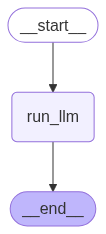

In [12]:
def run_llm(state):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke({"messages": trimmed_messages})
    new_message = chat_model.invoke(prompt)
    return {**state, "messages": [new_message]}


graph = StateGraph(state_schema=MessagesState)
graph.add_node("run_llm", run_llm)
graph.set_entry_point("run_llm")

checkpointer = InMemorySaver()
compiled_graph = graph.compile(checkpointer=checkpointer)

compiled_graph

# Run Loop

In [38]:
audio = record_audio_with_vad(
    sample_rate=settings.sample_rate, device=settings.sounddevice_input_device
)

🎤 Recording audio with VAD...
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Mean abs amplitude: 542.4547729492188
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Skipping during warm-up phase
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Mean abs amplitude: 435.4682922363281
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Skipping during warm-up phase
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Mean abs amplitude: 717.138671875
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Skipping during warm-up phase
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsamp

In [ ]:
thread_id = "1"


while True:
    print("🌴 Waiting for wake word...")
    if not wait_for_wake_word():
        break

    wait_until_sounddevice_device_available(
        settings.sounddevice_input_device, timeout=5.0
    )

    print("🎙️ Recording audio...")
    audio = record_audio_with_vad(
        sample_rate=settings.sample_rate, device=settings.sounddevice_input_device
    )

    print("🔊 Playing recorded audio...")
    play_audio(audio, sample_rate=settings.sample_rate)

    # print("📝 Transcribing...")
    # transcription_result = transcribe_audio_pvleopard_japanese(audio)
    # print(f"User said: {transcription_result}")

    # if not transcription_result:
    #     print("No transcription result. Exiting.")
    #     break

    # print("🤖 Running LLM...")
    # state = compiled_graph.invoke(
    #     input={"messages": [HumanMessage(transcription_result)]},
    #     config={"configurable": {"thread_id": thread_id}},
    # )

    # response = strip_thoughts(state["messages"][-1].content)
    # print(f"🤖 Response: {response}")

    # print("🔊 Speaking response...")
    # speak_text_with_google_gemini(response, volume=2.0)

🌴 Waiting for wake word...
Detected computer


Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768
Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768
Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768
Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768


🎙️ Recording audio...
🎤 Recording audio with VAD...
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: Speech detected
🧠 Speech detected. Start recording...
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: No speech detected
Waiting for audio...
Samples shape: (13

Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768
Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768
Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768
Expression 'ret' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1736
Expression 'AlsaOpen( hostApi, parameters, streamDir, &pcm )' failed in 'src/hostapi/alsa/pa_linux_alsa.c', line: 1768


🎙️ Recording audio...
🎤 Recording audio with VAD...
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: Speech detected
🧠 Speech detected. Start recording...
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: Speech detected
Waiting for audio...
Samples shape: (1323,), dtype: int16
Downsampling from 44100 Hz to 16000 Hz with GCD: 100
Downsampled shape: (480,), dtype: float32
Checking VAD for 960 bytes of audio
VAD result: No speech detected
Waiting for audio...
Samples shape: (13